# Plots for Content Africa study

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import mlab
import pandas as pd
import plotly.plotly as py
from plotly import tools
plt.style.use('classic')


def boxplot_sorted(df, by, column, rot=0):
    # use dict comprehension to create new dataframe from the iterable groupby object
    # each group name becomes a column in the new dataframe
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    # find and sort the median values in this new dataframe
    meds = df2.median().sort_values()
    # use the columns in the dataframe, ordered sorted by median value
    # return axes so changes can be made outside the function
    boxprops = dict(linewidth=2)
    return df2[meds.index].boxplot(rot=rot, return_type="axes", figsize=(20,10), boxprops=boxprops)

#not used
def removeOutliers(arr):
    elements = np.array(arr)
    elements = elements.astype(int)
    mean = np.mean(elements, axis=0)
    sd = np.std(elements, axis=0)
    
    final_list = [x for x in arr if (x > mean - 2 * sd)]
    final_list = [x for x in final_list if (x < mean + 2 * sd)]
        
    return final_list


DATA_PATH="../data/tables/views/"

mobile = []
price_mobile = []
desktop = []
price_desktop = []
with open(DATA_PATH+"domain_cost_view.csv","r") as csvfile:
    next(csvfile)
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    for row in reader:
        size_m = row[3]
        size_d = row[5]
        price_m = row[4]
        price_d = row[6]
        
        if (price_m == "NULL" or price_d == "NULL"):
            continue
        
        mobile.append(int(size_m)/1000)
        desktop.append(int(size_d)/1000)
        
        try:
            price_mobile.append(float(price_m))
            price_desktop.append(float(price_d))
        except:
            print(price_m)
            print(price_d)
        

## Africa 1GB basket price

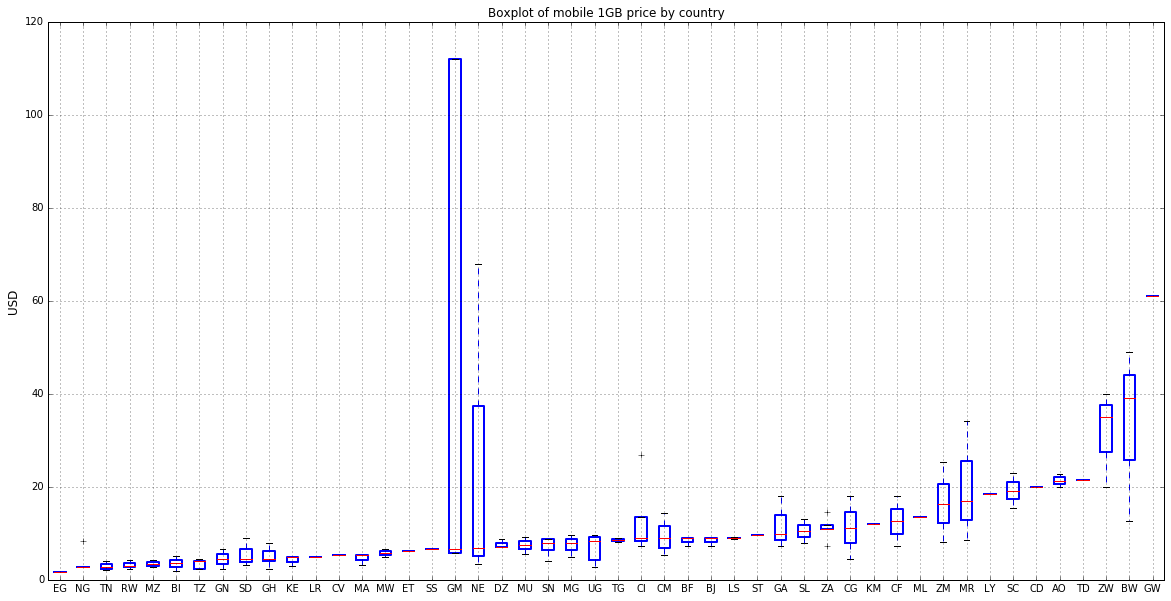

In [2]:
df = pd.read_csv('../data/tables/pricebasket.csv')

df1gb = df.loc[df['quarter']=='2017_Q4'].iloc[:,[0,3]]

axes = boxplot_sorted(df1gb, by=["cc"], column="price")
axes.figure.set_size_inches(20,10)
axes.set_title("Boxplot of mobile 1GB price by country")
axes.set_ylim([0,120])
axes.set_ylabel("USD", fontsize=12)

plt.savefig("../data/plots/boxplot_pricing.svg")
plt.show()

## Size and price of African websites
### Compare mobile vs desktop sizes (using urllib to get the size of the whole page)

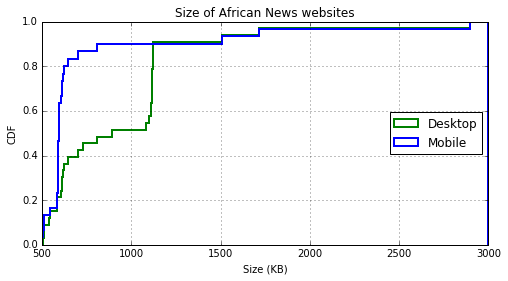

In [3]:
n_bins = 500

fig, ax = plt.subplots(figsize=(8, 4))

# plot the cumulative histogram
n, bins, patches = ax.hist([mobile, desktop], n_bins, density=1, histtype='step', range=[500, 3000], linewidth=2, 
                           cumulative=True, label=['Mobile', 'Desktop'])

# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
ax.set_title('Size of African News websites')
ax.set_xlabel('Size (KB)')
ax.set_ylabel('CDF')

plt.savefig("../data/plots/website_sizes.svg")
plt.show()

### Using size mobile as sum of webobjects

In [4]:
df = pd.read_csv('../data/tables/view_domain_cost_object_sum.csv', usecols=[1,3,5], sep=',', keep_default_na=0, 
                 dtype={'price_mobile': float}, skip_blank_lines=True)

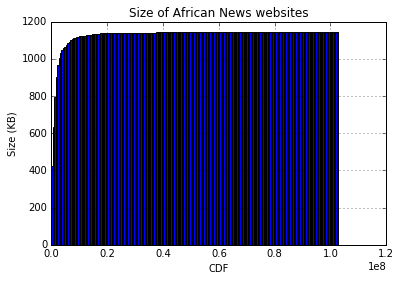

In [5]:
hist_plot = df['total_objects_size'].hist(bins=200, cumulative=True)
hist_plot.set_title("Web objects size total")
hist_plot.set_title('Size of African News websites')
hist_plot.set_xlabel('CDF')
hist_plot.set_ylabel('Size (KB)')
plt.show()

## Distribution of website sizes per country

/Users/amreesh/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



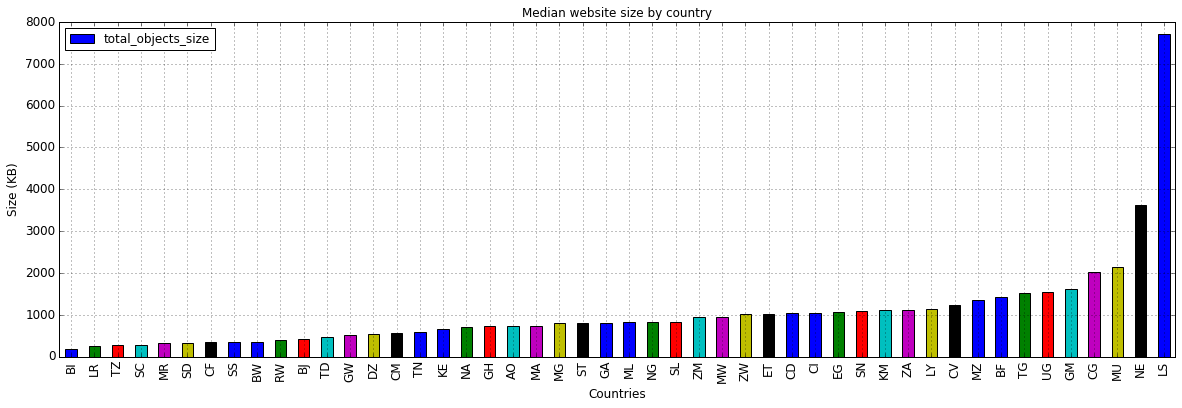

In [6]:
df_size_country = df.iloc[:,[0,1]]
df_size_country['total_objects_size'] = df_size_country['total_objects_size'].apply(lambda x: x/1024)

df_size_country_median = df_size_country.groupby(['cc'], as_index=False).median()

df_size_country_median = df_size_country_median.sort_values(by='total_objects_size')

ax = df_size_country_median.plot(kind='bar', by='cc', title ="Median website size by country", figsize=(20, 6), 
                                 fontsize=12, grid=True, x='cc', y='total_objects_size')
ax.set_xlabel("Countries", fontsize=12)
ax.set_ylabel("Size (KB)", fontsize=12)

plt.savefig("../data/plots/median_website_size_by_cc.svg")
plt.show()


## Distribution of price of accessing mobile websites per country

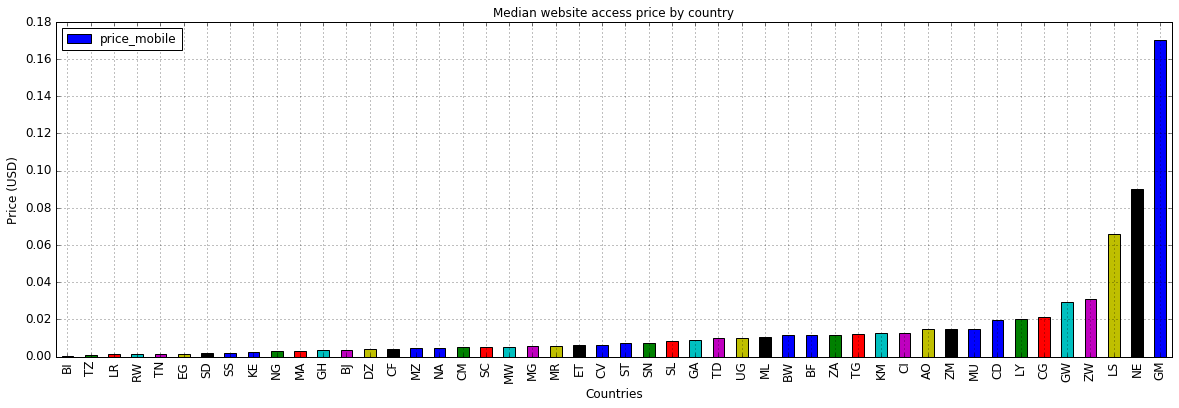

In [7]:
df_price_country = df.iloc[:,[0,2]]

#df_price_country['price_mobile'] = df_price_country['price_mobile'].astype(float)

df_price_country_median = df_price_country.groupby(['cc'], as_index=False).median()
df_price_country_median = df_price_country_median.sort_values(by='price_mobile')

ax = df_price_country_median.plot(kind='bar', by='cc', title ="Median website access price by country", figsize=(20, 6), 
                                 fontsize=12, grid=True, x='cc', y='price_mobile')
ax.set_xlabel("Countries", fontsize=12)
ax.set_ylabel("Price (USD)", fontsize=12)

plt.savefig("../data/plots/median_web_price_by_cc.svg")
plt.show()


## Price

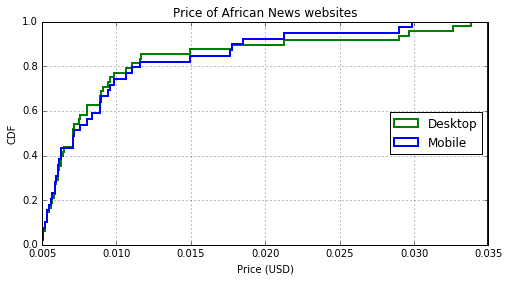

In [9]:
n_bins = 500

fig, ax = plt.subplots(figsize=(8, 4))

# plot the cumulative histogram
n, bins, patches = ax.hist([price_mobile, price_desktop], n_bins, density=1, histtype='step', range=[0.005, 0.035], linewidth=2, 
                           cumulative=True, label=['Mobile', 'Desktop'])
# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
ax.set_title('Price of African News websites')
ax.set_xlabel('Price (USD)')
ax.set_ylabel('CDF')

plt.savefig("../data/plots/website_price_to_access.svg")
plt.show()

## Barcharts exploring local vs remote hosting

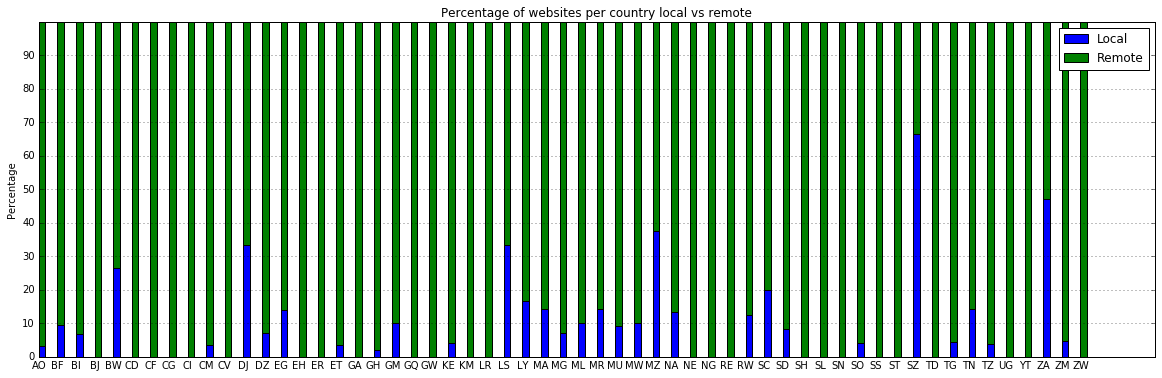

In [10]:
"""
========
Barchart
========

A bar plot with errorbars and height labels on individual bars
"""
label_cc = []
data_local = []
data_remote = []
count = 0
with open(DATA_PATH+"view_remote_local_websites_count_view.csv","r") as csvfile:
    next(csvfile)
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    for row in reader:
        cc = row[0]
        total = int(row[1])
        local = int(row[2])
        remote = int(row[3])
        
        label_cc.append(cc)
        data_local.append(100*local/total)
        data_remote.append(100*remote/total)
        count = count + 1
        
N = count

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence


plt.figure(figsize=(20, 6))

p1 = plt.bar(ind, data_local, width)
p2 = plt.bar(ind, data_remote, width,
             bottom=data_local)

plt.grid(True)
plt.ylabel('Percentage')
plt.title('Percentage of websites per country local vs remote')
plt.xticks(ind, label_cc)
plt.yticks(np.arange(0, 100, 10))
plt.legend((p1[0], p2[0]), ('Local', 'Remote'))

plt.savefig("../data/plots/percentage_website_local_vs_remote.svg")
plt.show()

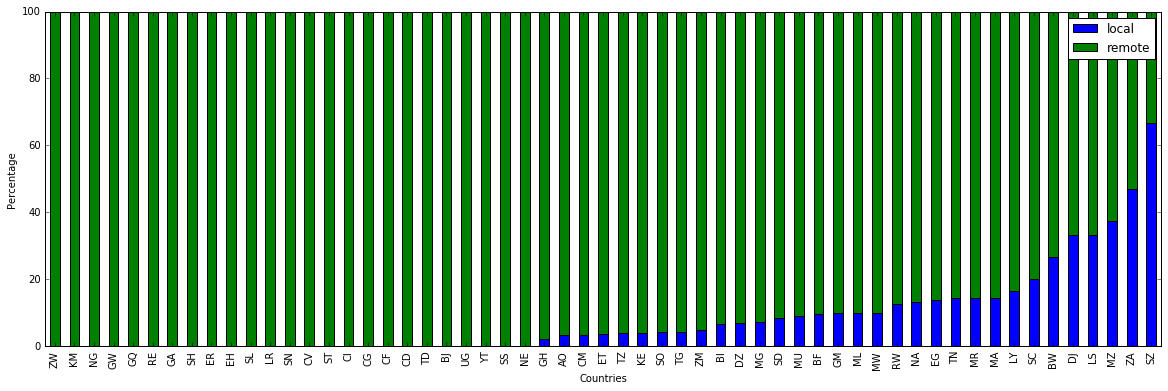

In [11]:
df = pd.DataFrame(columns=['cc','local','remote'])
df['cc'] = label_cc
df['local'] = data_local
df['remote'] = data_remote

df = df.sort_values(by='local', ascending=True)

df.plot.bar(stacked=True, figsize=(20,6), x='cc')
plt.ylabel('Percentage')
plt.xlabel('Countries')
plt.savefig("../data/plots/percentage_website_local_vs_remote_ordered.svg")
plt.show()

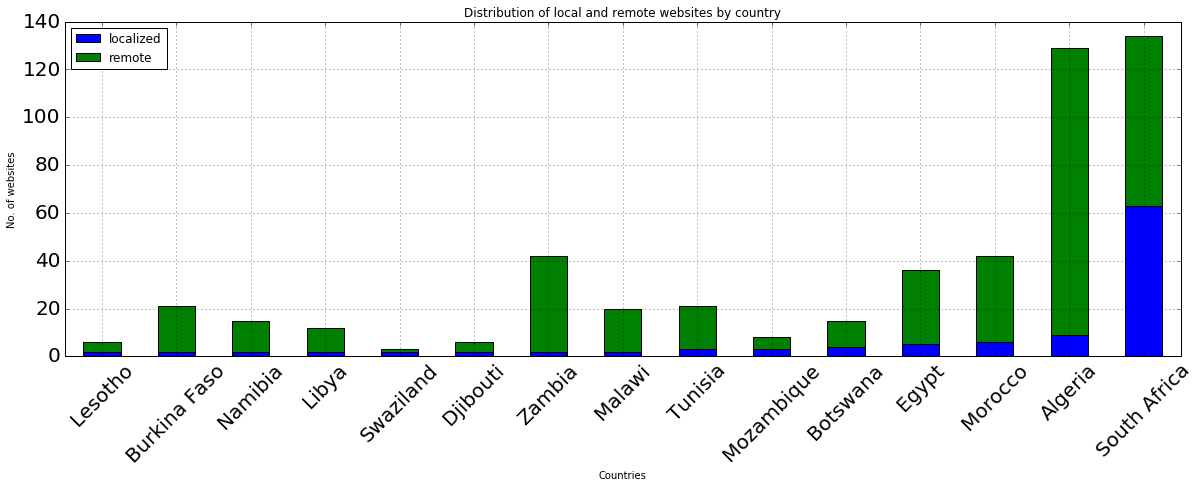

In [12]:
df = pd.read_csv("../data/tables/view_remote_local_websites_count.csv", sep=',', keep_default_na=0)
df = df.iloc[:,[0,1,3,4]]
df = df.sort_values(by='localized', ascending=True)

df = df.loc[df['localized'] > 1]

df.plot.bar(stacked=True, figsize=(20,6), x='countryname', rot=45, fontsize=20)
plt.ylabel('No. of websites')
plt.grid(True)
plt.title("Distribution of local and remote websites by country")
plt.xlabel('Countries')
plt.savefig("../data/plots/distribution_website_local_vs_remote.svg")
plt.show()

## Median and average of domain rtt values

In [13]:
remoteDict = {}
localDict = {}
medianRTT = {}
averageRTT = {}
medianLocalRTT = {}
medianRemoteRTT = {}
averageRemoteRTT = {}


with open(DATA_PATH+"domain_rtt_remote.csv","r") as csvfile:
    next(csvfile)
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    
    for row in reader:
        cc3 = row[0]
        cc = row[1]
        domain = row[2]
        rtt = int(row[3])
        
        try:
            remoteDict[cc].append(rtt)
        except:
            rttArray = []
            rttArray.append(rtt)
            remoteDict[cc] = rttArray
            
with open(DATA_PATH+"domain_rtt_local.csv","r") as csvfile:
    next(csvfile)
    reader = csv.reader(csvfile, delimiter=',', quotechar='"')
    
    for row in reader:
        try:
            cc3 = row[0]
            cc = row[1]
            domain = row[2]
            rtt = int(row[3])
        except:
            continue
        
        try:
            localDict[cc].append(rtt)
        except:
            rttArray = []
            rttArray.append(rtt)
            localDict[cc] = rttArray

for cc in remoteDict.keys():
    try:
        medianLocalRTT = np.median(localDict[cc])
        medianRemoteRTT = np.median(remoteDict[cc])
        
        averageLocalRTT = np.average(localDict[cc])
        averageRemoteRTT = np.average(remoteDict[cc])
        
        medianRTT[cc] = [medianLocalRTT, medianRemoteRTT]
        averageRTT[cc] = [averageLocalRTT, averageRemoteRTT]
    except:
        medianRTT[cc] = [0, medianRemoteRTT]
        averageRTT[cc] = [0, averageRemoteRTT]

### Median RTT Distribution by country

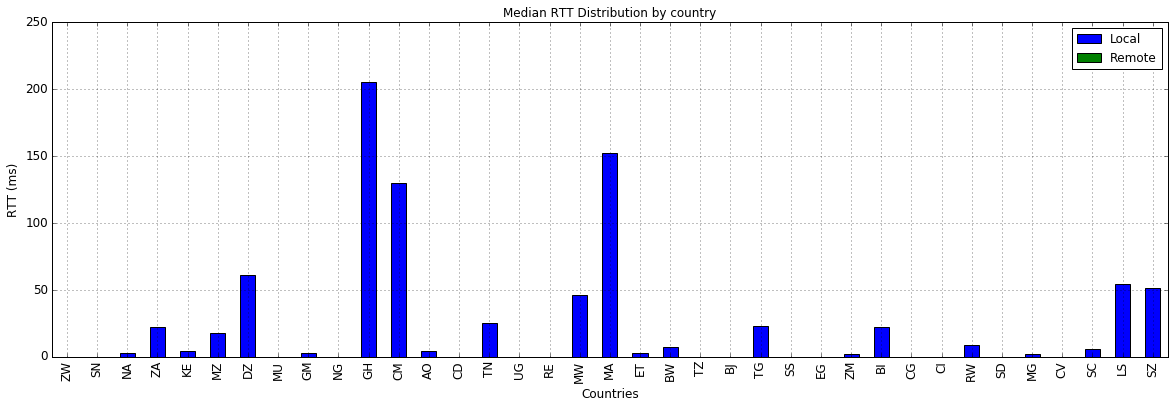

In [14]:
df = pd.DataFrame(data=medianRTT)
df = df.T

ax = df.plot(kind='bar', title ="Median RTT Distribution by country", figsize=(20, 6), legend=True, fontsize=12, grid=True)
ax.set_xlabel("Countries", fontsize=12)
ax.set_ylabel("RTT (ms)", fontsize=12)
plt.legend((p1[0], p2[0]), ('Local', 'Remote'))

plt.savefig("../data/plots/median_rtt_by_cc.svg")
plt.show()


### Average RTT Distribution by country

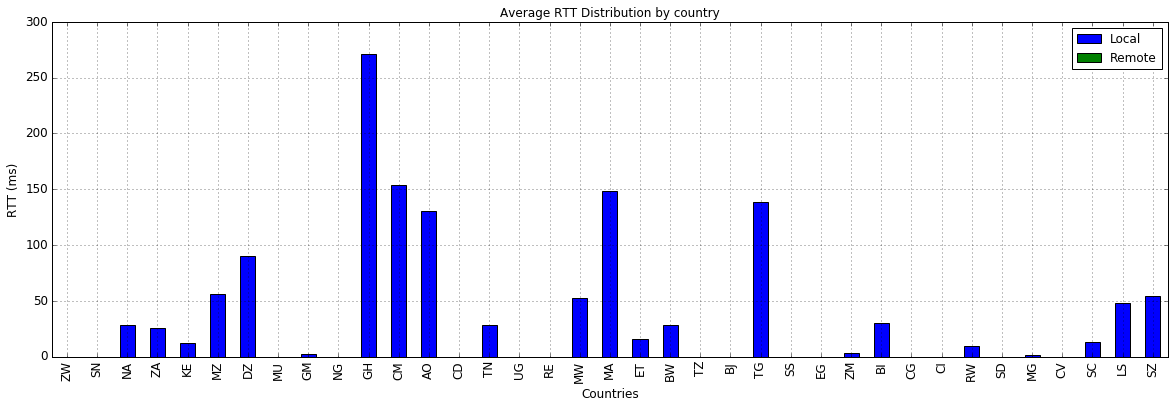

In [15]:
df = pd.DataFrame(data=averageRTT)
df = df.T

ax = df.plot(kind='bar', title ="Average RTT Distribution by country", figsize=(20, 6), legend=True, fontsize=12, grid=True)
ax.set_xlabel("Countries", fontsize=12)
ax.set_ylabel("RTT (ms)", fontsize=12)
plt.legend((p1[0], p2[0]), ('Local', 'Remote'))

plt.savefig("../data/plots/average_rtt_by_cc.svg")
plt.show()

# Maps

In [16]:
df_local = pd.read_csv(DATA_PATH+"domain_rtt_local.csv", usecols=[0,1,3], sep=',', keep_default_na=0)
df_remote = pd.read_csv(DATA_PATH+"domain_rtt_remote.csv", usecols=[0,1,3], sep=',', keep_default_na=0)

In [17]:
df_local_median = df_local.groupby(['cc3'], as_index=False).median()

data = [dict(
        type='choropleth',
        autocolorscale = True,
        locations = df_local_median['cc3'],
        z = df_local_median['rtt'].astype(float),
        locationmode = 'ISO-3',
        text = df_local_median['rtt'],
        marker = dict(
            line = dict (
                width = 1
            ) ),
        colorbar = dict(
            title = "RTT (ms)",
            x = 0.7
            )
        )]

layout = dict(
        title = 'RTT to locally hosted news websites',
        geo = dict(
            scope='africa',
            projection=dict( type='mercator' ),
            showlakes = False,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
py.iplot( fig, filename='d3-cloropleth-map' )



In [18]:
df_remote_median = df_remote.groupby(['cc3'], as_index=False).median()

data = [dict(
        type='choropleth',
        autocolorscale = True,
        locations = df_remote_median['cc3'],
        z = df_remote_median['rtt'].astype(float),
        locationmode = 'ISO-3',
        text = df_remote_median['rtt'],
        marker = dict(
            line = dict (
                width = 1
            ) ),
        colorbar = dict(
            title = "RTT (ms)",
            x = 0.7
            )
        )]

layout = dict(
        title = 'RTT to remotely hosted news websites',
        geo = dict(
            scope='africa',
            projection=dict( type='mercator' ),
            showlakes = False,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    

fig = dict( data=data, layout=layout )
py.iplot( fig, filename='d3-cloropleth-map' )


In [19]:
df_world = pd.read_csv("../data/tables/view_host_distribution.csv", usecols=[2,3], sep=',', keep_default_na=0)

data = [dict(
        type='choropleth',
        autocolorscale = True,
        locations = df_world['cc3'],
        z = df_world['percentage'].astype(float),
        locationmode = 'ISO-3',
        text = df_world['percentage'],
        marker = dict(
            line = dict (
                width = 1
            ) ),
        colorbar = dict(
            title = "Host distribution",
            x = 0.7
            )
        )]

layout = dict(
        title = 'Hosting distribution of African news website',
        geo = dict(
            scope='world',
            projection=dict( type='mercator' ),
            showlakes = False,
            lakecolor = 'rgb(255, 255, 255)'),
            width=1600,
            height=700,
             )
    

fig = dict( data=data, layout=layout )
py.iplot( fig, filename='d3-cloropleth-map' )

## Box plots

In [20]:
def boxplot_sorted(df, by, column, rot=0):
    # use dict comprehension to create new dataframe from the iterable groupby object
    # each group name becomes a column in the new dataframe
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    # find and sort the median values in this new dataframe
    meds = df2.median().sort_values()
    # use the columns in the dataframe, ordered sorted by median value
    # return axes so changes can be made outside the function
    boxprops = dict(linewidth=2)
    return df2[meds.index].boxplot(rot=rot, return_type="axes", figsize=(20,10), boxprops=boxprops)

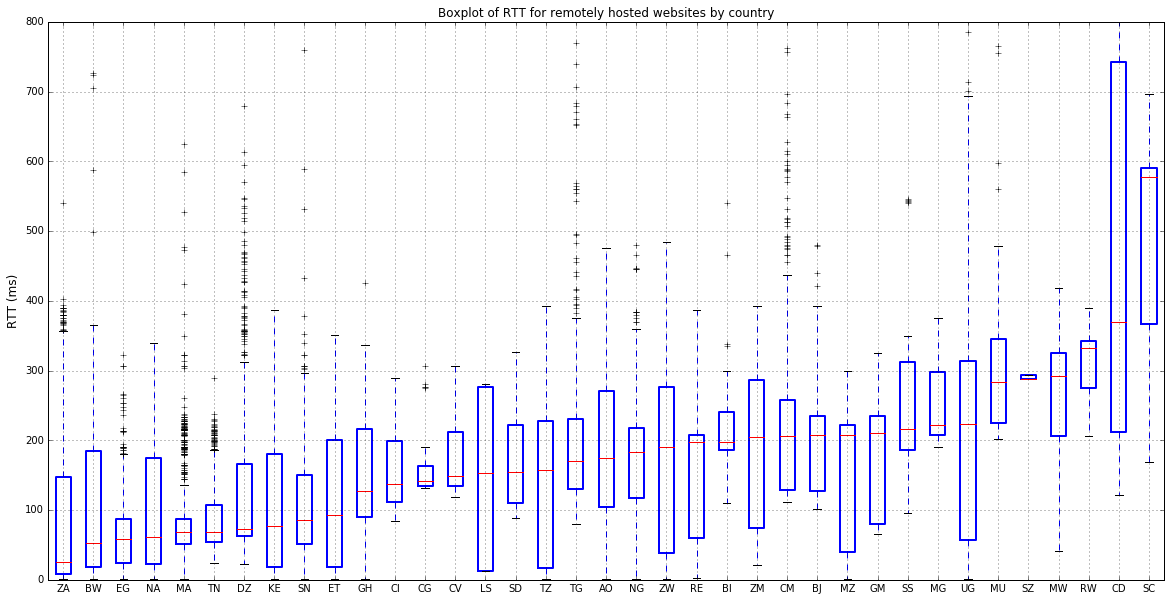

In [21]:
dslice_remote = df_remote.iloc[:,[1,2]]

axes = boxplot_sorted(dslice_remote, by=["cc"], column="rtt")
axes.figure.set_size_inches(20,10)
axes.set_title("Boxplot of RTT for remotely hosted websites by country")
axes.set_ylim([0,800])
axes.set_ylabel("RTT (ms)", fontsize=12)

plt.savefig("../data/plots/boxplot_rtt_remote.svg")
plt.show()

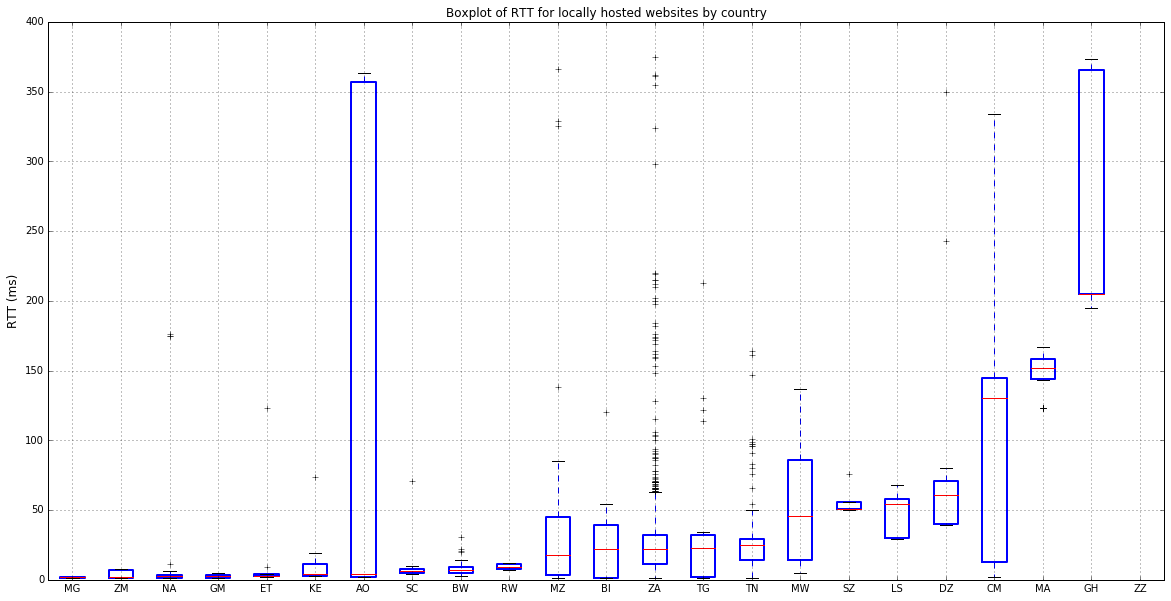

In [22]:
dslice_local = df_local.iloc[:,[1,2]]

axes = boxplot_sorted(dslice_local, by=["cc"], column="rtt")
axes.figure.set_size_inches(20,10)
axes.set_title("Boxplot of RTT for locally hosted websites by country")
axes.set_ylim([0,400])
axes.set_ylabel("RTT (ms)", fontsize=12)

plt.savefig("../data/plots/boxplot_rtt_local.svg")
plt.show()

## CDF of latency per country

In [24]:
# n_bins = 500

# fig, axs = plt.subplots(8, 5, figsize=(25, 25))

# ccs = remoteDict.keys()

# count=0
# for i in range(0,8):
#     for j in range(0,5):
#         count = count+1
        
#         if count == len(ccs):
#             break
        
#         cc = ccs[count]
#         remoteArray = remoteDict[cc]
        
        
#         try:
#             localArray = localDict[cc]
#             axs[i,j].hist([remoteDict[cc], localDict[cc]], n_bins, normed=1, histtype='step', cumulative=True, 
#                           linewidth=2, label=['Remote','Local'], color=['orange','royalblue'] )
#         except:
#             axs[i, j].hist(remoteDict[cc], n_bins, normed=1, histtype='step', cumulative=True, 
#                            linewidth=2, label='Remote', color='orange')
        
#         axs[i, j].set_title(ccs[count])
#         axs[i, j].set_xlabel('RTT (ms)')
#         axs[i, j].set_ylabel('CDF')

# fig.subplots_adjust(hspace=0.8, wspace=0.5)
# plt.savefig("../data/plots/latency_per_country_cdf.svg")
# plt.show()

## Exploring CDN usage

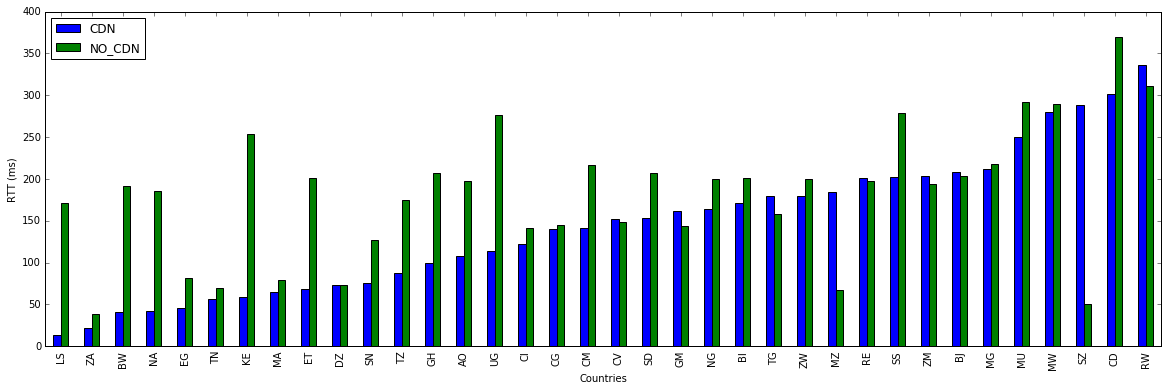

In [25]:
df_raw = pd.read_csv('../data/tables/view_domain_rtt2.csv', sep=',', keep_default_na=0)
df_rtt_cdn = df_raw.loc[df_raw['using_cdn']==1].iloc[:,[1,3]]
df_rtt_nocdn = df_raw.loc[df_raw['using_cdn']==0].iloc[:,[1,3]]

df_rtt_median_cdn = df_rtt_cdn.groupby(['cc'], as_index=False).median()
df_rtt_median_nocdn = df_rtt_nocdn.groupby(['cc'], as_index=False).median()

df = df_rtt_median_cdn.merge(df_rtt_median_nocdn, left_on='cc', right_on='cc', how='left')
df.columns = ['cc','CDN','NO_CDN']
df = df.sort_values(by='CDN')

df.plot.bar(x='cc', figsize=(20,6), label=['CDN','NO CDN'])
plt.ylabel("RTT (ms)")
plt.xlabel("Countries")
plt.savefig("../data/plots/Median_RTT_barplot_CDN_NOCDN.svg")
plt.show()

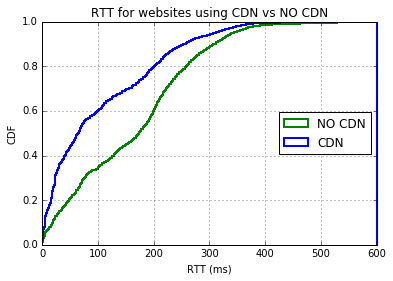

In [67]:
n_bins = 500

fig, ax = plt.subplots(figsize=(6, 4))

# plot the cumulative histogram
n, bins, patches = ax.hist([df_rtt_cdn['rtt'], df_rtt_nocdn['rtt']], n_bins, range=[0, 600], density=1, histtype='step', linewidth=2, 
                           cumulative=True, label=['CDN', 'NO CDN'])

# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
ax.set_title('RTT for websites using CDN vs NO CDN')
ax.set_xlabel('RTT (ms)')
ax.set_ylabel('CDF')

plt.savefig("../data/plots/RTT_CDF_CDN_NOCDN.pdf")
plt.show()

### Most used CDNs in Africa

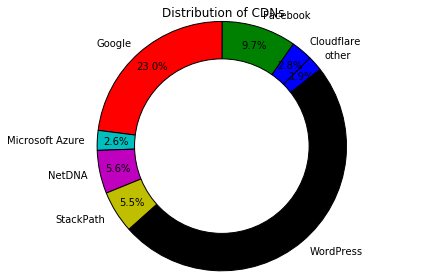

In [51]:
#most used CDNs by size
#CDNS with better RTT top 10?
#most used CDNs by country

df_domain_cdn = pd.read_csv('../data/tables/view_domain_cdn.csv', sep=',', keep_default_na=0, encoding="latin1")

df_by_size = df_domain_cdn.loc[df_domain_cdn['object_size'] > 0].iloc[:,[5,8]]
df_by_size = df_by_size.groupby('cdn_name', as_index=False).sum()

percentile = df_by_size.quantile(.50)['object_size']

df_cdn_upper = df_by_size.loc[df_by_size.object_size >= percentile]
df_cdn_lower = df_by_size.loc[df_by_size.object_size < percentile]

df_other = pd.DataFrame(columns=['cdn_name','object_size'])
df_other.loc[0] = ['other', df_cdn_lower['object_size'].sum()]

df_pie = [df_cdn_upper,df_other]

result = pd.concat(df_pie)

# Pie chart
labels = result['cdn_name'].values
sizes = result['object_size'].values

# #explsion
# explode = (0.05,0.05,0.05,0.05)
fig, ax2 = plt.subplots()
 
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=45, pctdistance=0.85)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax2.axis('equal') 
ax2.set_title("Distribution of CDNs")

plt.tight_layout()
plt.savefig("../data/plots/pie_chart_CDN.pdf")
plt.show()



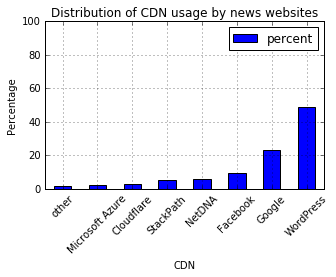

In [52]:
result['total'] = result['object_size'].sum()
result['percent'] = 100 * result['object_size'].div(result['total'])
result = result.iloc[:,[0,3]].sort_values(by='percent', ascending=True)
result.plot.bar(figsize=(5,3), x='cdn_name', rot=45, fontsize=10, ylim=(0,100))
plt.ylabel('Percentage')
plt.grid(True)
plt.title("Distribution of CDN usage by news websites")
plt.xlabel('CDN')
plt.savefig("../data/plots/distribution_website_percent_CDN.pdf")
plt.show()

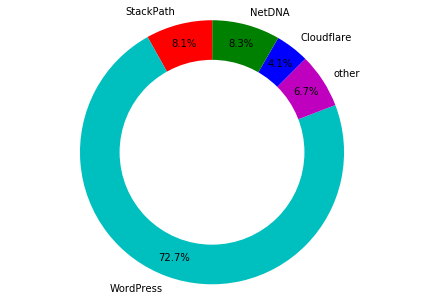

In [62]:
df_domain_cdn = pd.read_csv('../data/tables/view_domain_cdn.csv', sep=',', keep_default_na=0, encoding="latin1")

df_by_size = df_domain_cdn.loc[(df_domain_cdn['object_size'] > 0)].iloc[:,[5,8]]
df_by_size = df_domain_cdn.loc[(df_domain_cdn.cdn_name != 'Google') & (df_domain_cdn.cdn_name != 'Facebook')]

df_by_size = df_by_size.groupby('cdn_name', as_index=False).sum()

percentile = df_by_size.quantile(.70)['object_size']

df_cdn_upper = df_by_size.loc[df_by_size.object_size >= percentile]
df_cdn_lower = df_by_size.loc[df_by_size.object_size < percentile]

df_other = pd.DataFrame(columns=['cdn_name','object_size'])
df_other.loc[0] = ['other', df_cdn_lower['object_size'].sum()]

df_pie = [df_cdn_upper,df_other]

result = pd.concat(df_pie)

# Pie chart
labels = result['cdn_name'].values
sizes = result['object_size'].values

# #explsion
# explode = (0.05,0.05,0.05,0.05)
fig, ax2 = plt.subplots()
wedgeprops = {'linewidth': 0}
 
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=45, pctdistance=0.85, wedgeprops=wedgeprops )
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white',lw=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax2.axis('equal') 
#ax2.set_title("Distribution of CDNs")
plt.tight_layout()
plt.savefig("../data/plots/pie_chart_CDN_noGoogleAndFB.pdf")
plt.show()

### Best latency to CDNs in Africa

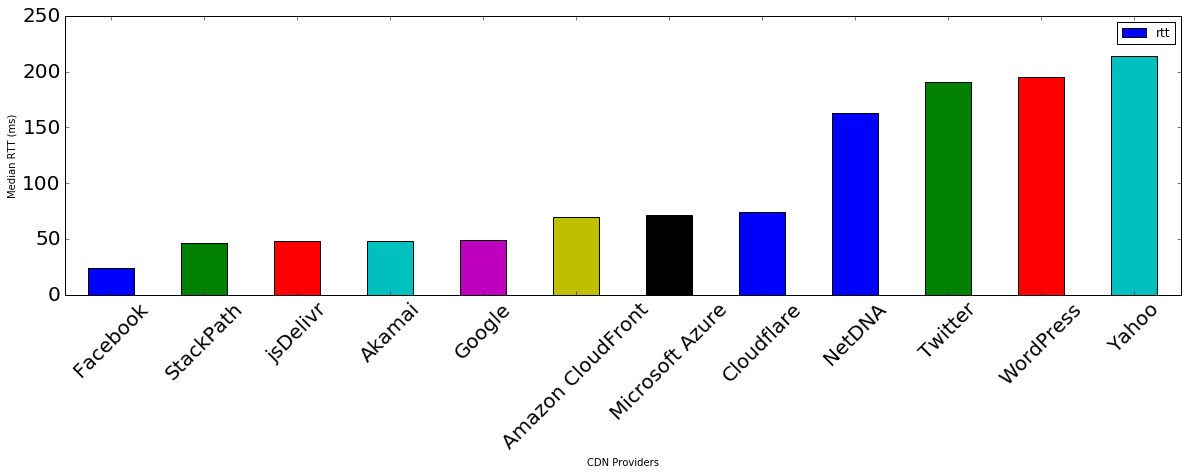

In [36]:
df_rtt_cdn = df_raw.loc[df_raw['using_cdn']==1].iloc[:,[1,2,3]]
df_domain_cdn = df_domain_cdn.iloc[:,[0,8]].drop_duplicates()

df = df_rtt_cdn.merge(df_domain_cdn, left_on='domain', right_on='domain', how='left')

df_global_median = (df.iloc[:,[2,3]]).groupby(['cdn_name'], as_index=False).median()

df_global_median = df_global_median.sort_values(by='rtt')
 
df_global_median.plot(kind="bar", y='rtt', x='cdn_name', rot=45, figsize=(20,5), fontsize=20)
plt.xlabel('CDN Providers')
plt.ylabel('Median RTT (ms)')
plt.savefig("../data/plots/bar_cdn_rtt_global.svg")
plt.show()

### Best latency to CDNs by country

In [38]:
df_cdn_country = df.iloc[:,[0,2,3]]

df_cdn_country = df_cdn_country.groupby(['cc','cdn_name'])['rtt'].median()

print (df_cdn_country)

cc  cdn_name         
AO  Akamai                56.5
    Google               269.0
    WordPress            108.0
BI  Amazon CloudFront    172.0
    Google               145.0
    jsDelivr             186.0
BJ  Facebook             107.5
    Google               199.0
    WordPress            250.0
BW  Facebook              44.0
    Google                39.0
CD  Cloudflare           343.5
    Facebook             435.5
    Google               340.5
    WordPress            220.0
CG  Amazon CloudFront    131.0
    Facebook             135.0
    Google               140.5
    WordPress            219.5
CI  Amazon CloudFront    123.0
    Cloudflare           204.0
    Google               111.0
    NetDNA               167.0
    WordPress            167.0
CM  Amazon CloudFront    143.0
    Cloudflare           124.0
    Facebook             141.0
    Google               140.0
    Twitter              142.0
CV  Cloudflare           143.0
                         ...  
TN  Google       

## Additional plots

In [68]:
df_local = pd.read_csv("../data/tables/views/domain_rtt_local.csv", sep=',', encoding='latin1', keep_default_na=False)
df_remote = pd.read_csv("../data/tables/views/domain_rtt_remote.csv", sep=',', encoding='latin1', keep_default_na=False)


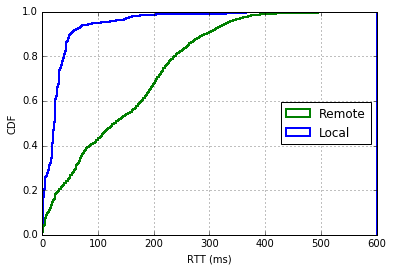

In [69]:
n_bins = 500

fig, ax = plt.subplots(figsize=(6, 4))
labels = ['Local', 'Remote']

#plot the cumulative histogram
n, bins, patches = ax.hist([df_local['rtt'].values, df_remote['rtt'].values], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,600],
                           cumulative=True, label=labels)
                                    
# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
#ax.set_title('Median RTT to News Websites')
ax.set_xlabel('RTT (ms)')
ax.set_ylabel('CDF')

plt.savefig("../data/plots/CDF_median_rtt_local_vs_remote.pdf")
plt.show()

In [70]:
df_hopcount = pd.read_csv("../data/tables/views/hop_count2.csv", sep=',', encoding='latin1', keep_default_na=False)
df_hopcount_local = df_hopcount.loc[df_hopcount['probe_cc'] == df_hopcount['hosting_cc1']]
df_hopcount_remote = df_hopcount.loc[df_hopcount['probe_cc'] != df_hopcount['hosting_cc1']]


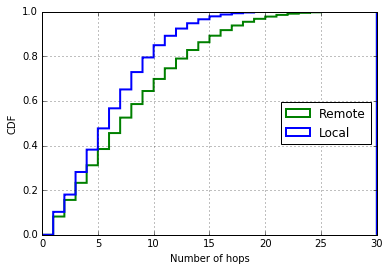

In [74]:
n_bins = 5000

fig, ax = plt.subplots(figsize=(6, 4))
labels = ['Local', 'Remote']

#plot the cumulative histogram
n, bins, patches = ax.hist([df_hopcount_local['hop_count'].values, df_hopcount_remote['hop_count'].values], 
                           n_bins, density=1, histtype='step', linewidth=2, range=[0,30],
                           cumulative=True, label=labels)
                                    
# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
#ax.set_title('Intermediate number of hops to News Websites')
ax.set_xlabel('Number of hops')
ax.set_ylabel('CDF')

plt.savefig("../data/plots/CDF_hopcount_local_vs_remote.pdf")
plt.show()

In [78]:
df_hopcount_local = df_hopcount_local.assign(Type='Local')
df_hopcount_remote = df_hopcount_remote.assign(Type='Remote')
df_hopcount_remote


,domain,probe_cc,hosting_cc1,hop_count,Type
0,breezefmchipata.com,ZM,DK,1,Remote
1,breezefmchipata.com,ZM,DK,2,Remote
2,breezefmchipata.com,ZM,DK,3,Remote
3,breezefmchipata.com,ZM,DK,4,Remote
4,breezefmchipata.com,ZM,DK,5,Remote
5,breezefmchipata.com,ZM,DK,6,Remote
6,breezefmchipata.com,ZM,DK,7,Remote
7,breezefmchipata.com,ZM,DK,8,Remote
8,breezefmchipata.com,ZM,DK,9,Remote
9,breezefmchipata.com,ZM,DK,10,Remote


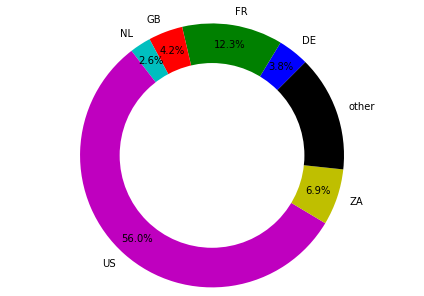

In [72]:
df_hopcount = pd.read_csv("../data/tables/views/hop_count.csv", sep=',', encoding='latin1', keep_default_na=True)

df_host_location = df_hopcount.iloc[:,[2]]

# #df_host_location = df_host_location.groupby(['hosting_cc1'], as_index=True).size()

df_cc = (df_hopcount.iloc[:,[2]]).groupby('hosting_cc1').size().reset_index(name='counts')

percentile = df_cc.quantile(.90)['counts']

df_cc_upper = df_cc.loc[df_cc.counts >= percentile]
df_cc_lower = df_cc.loc[df_cc.counts < percentile]

df_other = pd.DataFrame(columns=['hosting_cc1','counts'])
df_other.loc[0] = ['other', df_cc_lower['counts'].sum()]

df_pie = [df_cc_upper,df_other]

result = pd.concat(df_pie)

# Pie chart
labels = result['hosting_cc1'].values
sizes = result['counts'].values

# #explsion
# explode = (0.05,0.05,0.05,0.05)
fig, ax2 = plt.subplots()

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=45, pctdistance=0.850, wedgeprops = {'linewidth': 0}
)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white', lw=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax2.axis('equal') 
#ax2.set_title("Distribution of host locations")

plt.tight_layout()
plt.savefig("../data/plots/pie_chart_location_hosting_providers.pdf")
plt.show()

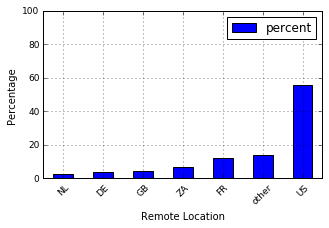

In [73]:
result['total'] = result['counts'].sum()
result['percent'] = 100 * result['counts'].div(result['total'])
result = result.iloc[:,[0,3]].sort_values(by='percent', ascending=True)
result.plot.bar(figsize=(5,3), x='hosting_cc1', rot=45, fontsize=9, ylim=(0,100))
plt.ylabel('Percentage')
plt.grid(True)
#plt.title("Distribution of host countries by news websites")
plt.xlabel('Remote Location')
plt.savefig("../data/plots/barplot_website_percent_CDN.pdf")
plt.show()